# Minimal Example 

In [1]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from datetime import datetime
import theano
import theano.tensor as tt

from scipy import stats
import os

import scipy as sp
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


To do: Find out why the negative values are sometimes after long rows of 0s 


All the features have to be changed from class to function

load_data_n_weeks()

In [2]:
def load_data_n_weeks(
    start,
    csv_path,
    seperator=",",
    pad = None
):
    ''' loads the data starting at a given timepoint
    Arguments:
        start (int): Days after '2020-03-05' to start the data (adapted for new date in LKOS data) NOT ENTIRELY SURE WHY WE WOULD START LATER TBH
        csv_path (str): Path to the file, inclusing the file name
        pad (int): How many days are going to be added (nan filled) at the end
    Returns:
        data (pd.df): Daframe with date as index, columns with countie IDs and values in cells.
    '''    
    

    data = pd.read_csv(csv_path, sep=seperator, encoding='iso-8859-1', index_col=0)

    data.index = [pd.Timestamp(date) for date in data.index]
    start_day = pd.Timestamp('2020-03-05') + pd.Timedelta(days=start) #changes for new start day
    data = data.loc[start_day <= data.index]

    if pad is not None:
        last_date = data.index[-1]
        extended_index = pd.date_range(last_date + pd.Timedelta(days=1),
                                       last_date + pd.Timedelta(days=pad))
        for x in extended_index:
            data = data.append(pd.Series(name=x))

    data.index = [pd.Timestamp(date) for date in data.index]

    return data

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


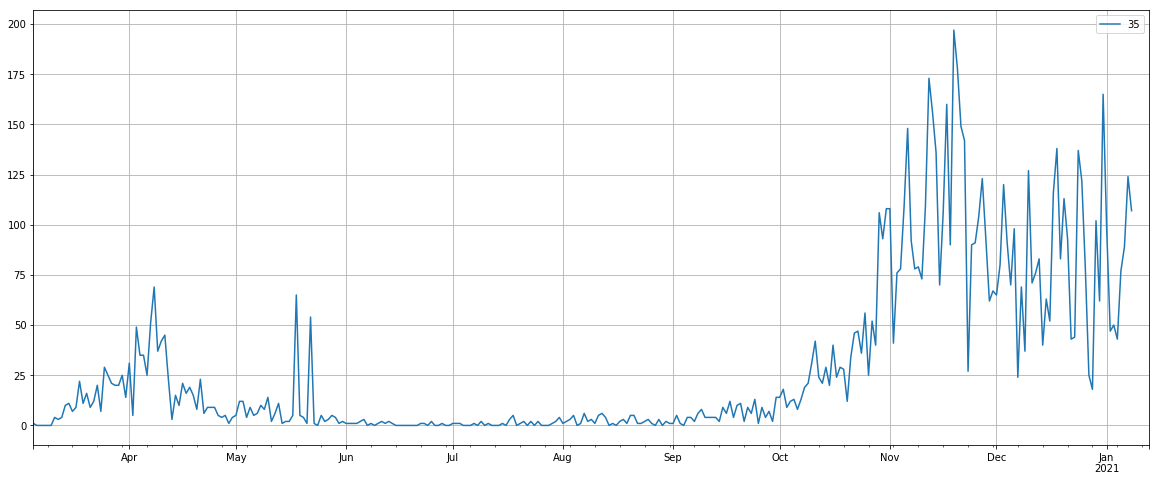

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
data = load_data_n_weeks(0, parent_directory + "\\preprocessedLKOS.csv", pad = 5)
data_short = data.iloc[:,35:36] # just Osnabrrücker Land /or Stadt I think
data_short.plot(grid = True, figsize = (20,8))

split_data

In [5]:
def split_data(
    data,
    train_start,
    test_start,
    post_test
):
    """
        split_data(data,data_start,train_start,test_start)

    Utility function that splits the dataset into training and testing data as well as the corresponding target values.

    Returns:
    ========
        data_train:     training data (from beginning of records to end of training phase)
        target_train:   target values for training data
        data_test:      testing data (from beginning of records to end of testing phase = end of records)
        target_test:    target values for testing data
    """

    target_train = data.loc[(train_start <= data.index)
                            & (data.index < test_start)]
    target_test = data.loc[(test_start <= data.index)
                           & (data.index < post_test)]

    data_train = data.loc[data.index < test_start]
    data_test = data

    return data_train, target_train, data_test, target_test


Some default values, same as in original 

In [6]:
 # Default Values
number_of_weeks = 3
days_into_future = 5
start = 0
start_date = pd.Timestamp("2020-03-20") + pd.Timedelta(days=start)


csv_path = parent_directory + "\\preprocessedLKOS.csv"

# should move this further down
num_chains = 2 
num_cores = num_chains
trend_order = 1
periodic_order = 4
use_report_delay = False
use_demographics = True
   


Definitions of all features

In [7]:
def spatio_temporal_feature(times, locations):
    _times = [datetime.strptime(d, "%Y-%m-%d") for d in times]
    return np.asarray(_times).reshape((-1, 1)), np.asarray(locations).reshape((1, -1)).astype(np.float32)    

def spatio_temporal_yearly_demographics_feature(locations):
    demographic = 32289 # randomly picked an example value (GMH in 2008)
    return demographic

def temporal_polynomial_feature(t, t0, tmax, order):
    #print(order)
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tmax = datetime.strptime(tmax, "%Y-%m-%d")

    scale = (tmax - t0).days # (pd.Datetime - pd.Datetime).days -> differenz in tagen (int)
    #print(scale)
    t_delta = (t - t0).days / scale
    #print("delta", t_delta)
    #print( "times order ", t_delta ** order)
    return t_delta ** order
#TemporalFourierFeature(SpatioTemporalFeature)

def temporal_periodic_polynomial_feature(t0, t, period, order):
    # what does period mean? 
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tdelta = (t-t0).days % period
    return (tdelta / period) ** order
    
def temporal_sigmoid_feature(t0, t, scale):
    # what does scale do here?
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_delta = (t - t0) / scale
    return sp.special.expit(t_delta.days + (t_delta.seconds / (3600 * 24)))


def report_delay_polynomial_feature(t0, t, t_max, order):#
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_max = datetime.strptime(t_max, "%Y-%m-%d")
    scale = (t_max - t0).days
    _t = 0 if t <= t0 else (t - t0).days / scale
    return _t ** order

#trange: t0 to tmax
# t0: anfang zeitraum
# t anfang nowcast
# tmax last day foreacast

In [8]:

# What is i, what makes sense for trend_poly_order, periodic_poly_order, report_delay_order?

def features(trange, order, demographic,  include_temporal = True, include_periodic = True, 
             include_demographics = True, include_report_delay = False ):
    #print("features", order)
    trend_poly_order = order
    periodic_poly_order = order
    report_delay_order = order # What values make sense here??
    feature_collection = {
                "temporal_trend": {
                    "temporal_polynomial_{}".format(i): temporal_polynomial_feature(
                        trange[0], trange[1],trange[2], i
                    )
                    for i in range(trend_poly_order + 1)
                }
                if include_temporal
                else {},
                "temporal_seasonal": {
                    "temporal_periodic_polynomial_{}".format(
                        i
                    ): temporal_periodic_polynomial_feature(trange[0],trange[1], 7, i)
                    for i in range(periodic_poly_order + 1)
                }
                if include_periodic
                else {},


                "temporal_report_delay": {
                    "report_delay": report_delay_polynomial_feature(
                        trange[0],trange[1], trange[2], report_delay_order # 
                    )
                }
                if include_report_delay
                else {},
                "exposure": {
                    "exposure":  demographic * 1.0 / 100000
                }
                ###

    }

    return feature_collection

'''
{'temporal_trend': {'temporal_polynomial_0': 1.0, 'temporal_polynomial_1': -0.75, 'temporal_polynomial_2': 0.5625, 'temporal_polynomial_3': -0.421875}, 
'temporal_seasonal': {'temporal_periodic_polynomial_0': 1.0, 'temporal_periodic_polynomial_1': 0.2857142857142857, 'temporal_periodic_polynomial_2': 0.08163265306122448, 'temporal_periodic_polynomial_3': 0.02332361516034985}, 
'spatiotemporal': {}, 
'temporal_report_delay': {'report_delay': 0.014458261438686257}, 'exposure': {'exposure': 0.32289}}
'''

"\n{'temporal_trend': {'temporal_polynomial_0': 1.0, 'temporal_polynomial_1': -0.75, 'temporal_polynomial_2': 0.5625, 'temporal_polynomial_3': -0.421875}, \n'temporal_seasonal': {'temporal_periodic_polynomial_0': 1.0, 'temporal_periodic_polynomial_1': 0.2857142857142857, 'temporal_periodic_polynomial_2': 0.08163265306122448, 'temporal_periodic_polynomial_3': 0.02332361516034985}, \n'spatiotemporal': {}, \n'temporal_report_delay': {'report_delay': 0.014458261438686257}, 'exposure': {'exposure': 0.32289}}\n"

In [9]:
def datetimeadaptions(date): # I don't like myself for doing this
    year = str(date)[:4] 
    month = str(date)[5:7]
    day = str(date)[8:10]
    return year+"-"+month+"-"+day

def evaluate_features(days, counties, polynom_order=3):
    #print("evaluate_features" , polynom_order)
    # welches polynom_order
    demographic = 20000 # random value
    all_features = pd.DataFrame()
    #print(counties)
    for day in days:

        trange = [datetimeadaptions(day), datetimeadaptions(day+ pd.Timedelta(days=21)), datetimeadaptions(day+ pd.Timedelta(days=31)) ] #first train, beginn nowcast, end forecast

        for county in counties:

            feature = features(trange, polynom_order, demographic, 
                               include_temporal = True, include_periodic = True, include_demographics = True, include_report_delay = True)
            
            feature['date'] = datetimeadaptions(day)
            feature['ID'] = county
            feature_df = pd.DataFrame.from_dict(feature)
            #print(feature_df)
            all_features = all_features.append(feature_df)
    #print("Und hier sind alle features aus evaluate features", all_features)        
    return all_features
            #print(feature)
            # wie sollen die zusammengestackt und sortiert werden?
            # wo sind da irgendwelche Werte drin? die sind ncoh alle gleich
    

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [16]:
def get_features(target, poly_order = 3):
    days, counties = target.index, target.columns
    # extract features
    
    all_features = evaluate_features(days, counties, polynom_order = poly_order)
    
    all_features.astype(float, errors = 'ignore')
    #print(all_features)
    Y_obs = target.stack().values.astype(np.float32)
    #print("This is Y_obs \n")
    #print(Y_obs)
    
    T_S = all_features.filter(regex = "temporal_periodic_polynomial_0", axis = 0).dropna(axis = 1)#.values.astype(np.float32) #features["temporal_seasonal"].values.astype(np.float32)
    T_S = T_S.sort_values(["date", "ID"])
    #print("This is T_S \n")
    #print(T_S)
    T_S = T_S['temporal_seasonal'].to_numpy()

    T_S = T_S.reshape(len(Y_obs), -1)
    
    T_T = all_features.filter(regex = "temporal_polynomial_\d", axis = 0).dropna(axis = 1) #features["temporal_trend"].values.astype(np.float32)
    T_T = T_T.sort_values([ "date","ID"])
    T_T = T_T["temporal_trend"].to_numpy()
    T_T = T_T.reshape(len(Y_obs), -1)
    
    T_D = all_features.filter(regex = "report_delay", axis = 0).dropna(axis = 1) #features["temporal_report_delay"].values.astype(np.float32)
    T_D = T_D.sort_values(["date", "ID"])
    T_D = T_D["temporal_report_delay"].to_numpy()
    T_D = T_D.reshape(len(Y_obs), -1)
    
    exposure = all_features.filter(regex = "exposure", axis = 0).dropna(axis = 1) #features["spatiotemporal"].values.astype(np.float32)
    exposure = exposure.sort_values(["date", "ID"])
    exposure = exposure["exposure"].to_numpy()
    exposure = exposure.reshape(len(Y_obs), -1)
    # has to be sorted I guess? order matches the one of Y_obs =) 
    return [Y_obs, T_S, T_T, T_D, exposure]

In [11]:
data = load_data_n_weeks(start, csv_path, pad=days_into_future)

# According to OC (Original Code) For the simple model, only targets are required 
data_train, target_train, data_test, target_test = split_data(
    data,
    train_start=start_date,
    # test_start=last_day - pd.Timedelta(days=days_into_future+4),
    test_start=start_date + pd.Timedelta(days=number_of_weeks * 7),
    post_test=start_date + pd.Timedelta(days=number_of_weeks * 7 + 10),
)


tspan = (target_train.index[0], target_train.index[-1])
#print("CHECK")
#print(start)
#print(start_date)
#print(tspan)
print(target_train)

              00   01   02   03   04   05   06    07   08   09  ...   27   28  \
2020-03-20   0.0  1.0  0.0  1.0  0.0  1.0  1.0   1.0  0.0  1.0  ...  0.0  0.0   
2020-03-21   2.0  0.0  0.0  2.0  0.0  0.0  4.0   0.0  0.0  0.0  ...  0.0  0.0   
2020-03-22   1.0  1.0  0.0  2.0  0.0  0.0  0.0   2.0  2.0  1.0  ...  0.0  0.0   
2020-03-23  -2.0  3.0  0.0 -1.0  1.0  2.0 -3.0   3.0  0.0  3.0  ...  1.0  0.0   
2020-03-24   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
2020-03-25   0.0  1.0  0.0  0.0  0.0  0.0  3.0   3.0  1.0  5.0  ...  0.0  0.0   
2020-03-26   0.0  2.0  2.0  4.0  1.0  2.0  0.0   1.0  0.0  2.0  ...  0.0  0.0   
2020-03-27   2.0  3.0  1.0  1.0  0.0  0.0 -1.0   2.0  0.0  1.0  ...  0.0  0.0   
2020-03-28   0.0  1.0  0.0  0.0  0.0  2.0  0.0   2.0  0.0  2.0  ...  0.0  0.0   
2020-03-29   3.0  1.0  0.0  0.0  1.0  0.0  0.0   5.0  1.0  0.0  ...  0.0  0.0   
2020-03-30   3.0  4.0  0.0  1.0  2.0  3.0  0.0   2.0  0.0  1.0  ...  0.0  0.0   
2020-03-31   0.0  1.0  0.0  

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [21]:
def model(features, data):
    target = features[0]
    #print(target)
    T_S = features[1] 
    T_T = features[2] 
    T_D = features[3] 
    exposure = features[4]
    days, counties = data.index, data.columns
    
    log_exposure = np.log(exposure)#.values.astype(np.float32).ravel())
    num_obs = np.prod(target.shape)
    num_t_s = T_S.shape[1]
    num_t_t = T_T.shape[1]
    num_t_d = T_D.shape[1]
    #num_ts = TS.shape[1]
    num_counties = len(counties)
    with pm.Model() as model:
        # priors
        # δ = 1/√α
        δ = pm.HalfCauchy("δ", 10, testval=1.0)
        α = pm.Deterministic("α", np.float32(1.0) / δ)

        W_t_s = pm.Normal(
            "W_t_s", mu=0, sd=10, testval=np.zeros(num_t_s), shape=num_t_s
        )
        W_t_t = pm.Normal(
            "W_t_t",
            mu=0,
            sd=10,
            testval=np.zeros((num_counties, num_t_t)),
            shape=(num_counties, num_t_t),
        )

        W_t_d = pm.Normal(
            "W_t_d", mu=0, sd=10, testval=np.zeros(num_t_d), shape=num_t_d
        )
#         W_ts = pm.Normal(
#             "W_ts", mu=0, sd=10, testval=np.zeros(num_ts), shape=num_ts
#         )

        param_names = ["δ", "W_t_s", "W_t_t", "W_t_d"]#, "W_ts"]
        params = [δ, W_t_s, W_t_t, W_t_d]#, W_ts]

        expanded_Wtt = tt.tile(
            W_t_t.reshape(shape=(1, num_counties, -1)), reps=(21, 1, 1)
        )
        expanded_TT = np.reshape(T_T, newshape=(21, num_counties, 4)) # was 21, num_counties, 2 (why two? Why 4? )
        result_TT = tt.flatten(tt.sum(expanded_TT * expanded_Wtt, axis=-1))

        # calculate mean rates
        μ = pm.Deterministic(
            "μ",
            tt.exp(
                tt.dot(T_S, W_t_s)
                + result_TT
                + tt.dot(T_D, W_t_d)
                #+ tt.dot(TS, W_ts)
                + log_exposure
            ),
        )
        # constrain to observations
        pm.NegativeBinomial("Y", mu=μ, alpha=α, observed=target)
    return model

In [22]:

features_for_model = get_features(target_train)
#print(features_for_model[0])
model = model(features_for_model, target_train)
#trace = sample_model(model)

In [ ]:
def sample_parameters(
        target,
        n_init=100,
        samples=1000,
        chains=2,
        init="advi",
        target_accept=0.8,
        max_treedepth=10,
        **kwargs
    ):
        """
            sample_parameters(target, samples=1000, cores=8, init="auto", **kwargs)

        Samples from the posterior parameter distribution, given a training dataset.
        The basis functions are designed to be causal, i.e. only data points strictly
        predating the predicted time points are used (this implies "one-step-ahead"-predictions).
        """

        #self.init_model(target)

        
        with model:
            # run!
            nuts = pm.step_methods.NUTS(
                vars=self.params,
                target_accept=target_accept,
                max_treedepth=max_treedepth,
            )
            trace = pm.sample(
                samples,
                nuts,
                chains=chains,
                cores=cores,
                compute_convergence_checks=False,
                **kwargs
            )
        return trace

In [ ]:
def sample_predictions(
    target_days,
    target_counties,
    parameters,
    prediction_days,
    average_periodic_feature=False,
    average_all=False,
    init="auto",
):
    num_counties = len(target_counties) # check this again
    all_days = pd.DatetimeIndex(
        [d for d in target_days] + [d for d in prediction_days]
    )

    # extract features
    features = self.evaluate_features(all_days, target_counties)
    # num_counties = 412 #hardcoded; not needed?
    T_S = features["temporal_seasonal"].values
    T_T = features["temporal_trend"].values
    T_D = features["temporal_report_delay"].values
    TS = features["spatiotemporal"].values
    log_exposure = np.log(features["exposure"].values.ravel())

    if average_periodic_feature:
        T_S = np.reshape(T_S, newshape=(-1, num_counties, 5))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(T_S.shape[0], 1, 1)), (-1, 5))

    if average_all:
        T_S = np.reshape(T_S, newshape=(31, num_counties, -1))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1, 5))

        TS = np.reshape(TS, newshape=(31, num_counties, -1))
        mean = np.mean(TS, axis=0, keepdims=True)
        TS = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1, 3))

        T_D = np.reshape(T_D, newshape=(31, num_counties, -1))
        mean = np.mean(T_D, axis=0, keepdims=True)
        T_D = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1))

        log_exposure = np.reshape(log_exposure, newshape=(31, num_counties))
        mean = np.mean(log_exposure, axis=0, keepdims=True)
        log_exposure = np.reshape(np.tile(mean, reps=(31, 1)), (-1))

    # extract coefficient samples
    α = parameters["α"]
    W_t_s = parameters["W_t_s"]
    W_t_t = parameters["W_t_t"]
    W_t_d = parameters["W_t_d"]
    W_ts = parameters["W_ts"]

   
    num_predictions = len(target_days) * len(target_counties) + len(
        prediction_days
    ) * len(target_counties)
    num_parameter_samples = α.size
    y = np.zeros((num_parameter_samples, num_predictions), dtype=int)
    μ = np.zeros((num_parameter_samples, num_predictions), dtype=np.float32)

    expanded_Wtt = np.tile(
        np.reshape(W_t_t, newshape=(-1, 1, num_counties, 2)), reps=(1, 31, 1, 1)
    )
    expanded_TT = np.reshape(T_T, newshape=(1, 31, num_counties, 2))
    result_TT = np.reshape(
        np.sum(expanded_TT * expanded_Wtt, axis=-1), newshape=(-1, 31 * num_counties)
    )

    # NOTE: the delay polynomial is left out here!
    # mean_delay /= num_parameter_samples
    
    for i in range(num_parameter_samples):
        μ[i, :] = np.exp(
            np.dot(T_S, W_t_s[i])
            + result_TT[i]
            + np.dot(TS, W_ts[i])
            + np.dot(T_D, W_t_d[i])
            + log_exposure
        )
        y[i, :] = pm.NegativeBinomial.dist(mu=μ[i, :], alpha=α[i]).random()

    return {"y": y, "μ": μ, "α": α}

In [ ]:

#print(days, counties)

# extract features
#features = self.evaluate_features(days, counties) # dict ^ "all_features"
#Y_obs = target.stack().values.astype(np.float32)


T_S = np.array(list(features["temporal_seasonal"].values())).astype(np.float32) # collect "tensors" for group "temporal_seasonal" 
print(T_S)
T_T = np.array(list(features["temporal_trend"].values())).astype(np.float32) # collect ...
T_D = np.array(list(features["temporal_report_delay"].values())).astype(np.float32) # ...
TS = np.array(list(features["spatiotemporal"].values())).astype(np.float32) # ... as numpy arrays! (m x n x p) - array
print(T_T, T_D, TS)
log_exposure = np.log(np.array(list(features["exposure"].values())).astype(np.float32).ravel())
print(log_exposure)